# Marketing EDA and visualization
### This is a demo project of showcasing EDA through visualization and data transformation

# Contents
- ### Data preparation
- [Importing libraries](#Importing-libraries)
- [Data cleaning pipeline](#Data-cleaning-pipeline)
- ### EDA and visualization
- [Numerical features](#Numerical-features)
- [Categorical features](#Categorical-features)
- ### Handling outliers
- [Data transformation](#Data-transformation)

## Importing libraries
*First we import all the required libraries, then we are going to create a pipeline returning a cleaned dataset ready for analysis* **==>**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox

#### End of importing section. Click [here](#Contents) to navigate back to contents.

## Data cleaning pipeline

In [2]:
def pipeline(path='data/marketing_analysis.csv'):
    '''The data cleaning pipeline takes a filepath as argument and returns a cleaned dataframe.
    After standardizing column names, it drops columns whithout descriptive value or too many NaNs.'''
    
    data = pd.read_csv(path)
    data.columns = list(data.columns
                        .str.lower()
                        .str.replace(' ','_')
                        )
    data = (data[data['income']>0]
            .drop(columns=['unnamed:_0', 'customer', 'vehicle_type'])
            .drop_duplicates()
            .dropna()
            .reset_index(drop=True)
            )
    data[data.select_dtypes('number').columns] = data.select_dtypes('number').astype('int32')
    data.loc[data['policy'].isin(['Personal L3','Personal L2','Personal L1']),'policy'] = 'Personal'
    data.loc[data['policy'].isin(['Corporate L3','Corporate L2','Corporate L1']), 'policy'] = 'Corporate'
    data.loc[data['policy'].isin(['Special L3','Special L2','Special L1']), 'policy'] = 'Special'
    data.loc[data['vehicle_class'].isin(['Luxury SUV', 'Luxury Car']), 'vehicle_class'] = 'Luxury'
    data.loc[data['vehicle_class'].isin(['Four-Door Car', 'SUV']), 'vehicle_class'] = 'Four-Door Car'
    data[data.select_dtypes('object').columns] = data.select_dtypes('object').astype('category')
    return data
    
df = pipeline()

#### End of data cleaning pipeline section. Click [here](#Contents) to navigate back to contents.

## Numerical features

*The summary statistics is a good initial step as it can tell a lot of the data in a single step. Let`s check the numerical features first* **==>**

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_lifetime_value,6675.0,8136.428914,6946.780820,2119.0,4098.0,5824.0,9075.0,83325.0
income,6675.0,50593.521049,24278.962458,10037.0,28573.0,48207.0,70263.0,99981.0
monthly_premium_auto,6675.0,92.924345,34.521787,61.0,68.0,83.0,109.0,297.0
months_since_last_claim,6675.0,15.050037,10.073042,0.0,6.0,14.0,23.0,35.0
months_since_policy_inception,6675.0,47.835206,27.912248,0.0,24.0,47.0,71.0,99.0
number_of_open_complaints,6675.0,0.383820,0.905702,0.0,0.0,0.0,0.0,5.0
number_of_policies,6675.0,2.955655,2.391702,1.0,1.0,2.0,4.0,9.0
total_claim_amount,6675.0,376.160749,252.239350,0.0,208.5,340.0,497.0,2893.0


*next we can check the collinearity* **==>**

<AxesSubplot:>

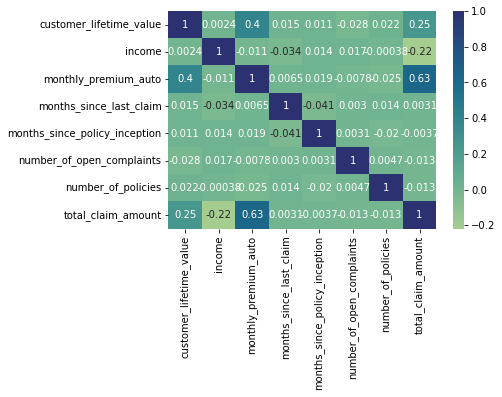

In [4]:
sns.heatmap(data=df.corr(), annot=True, cmap='crest')

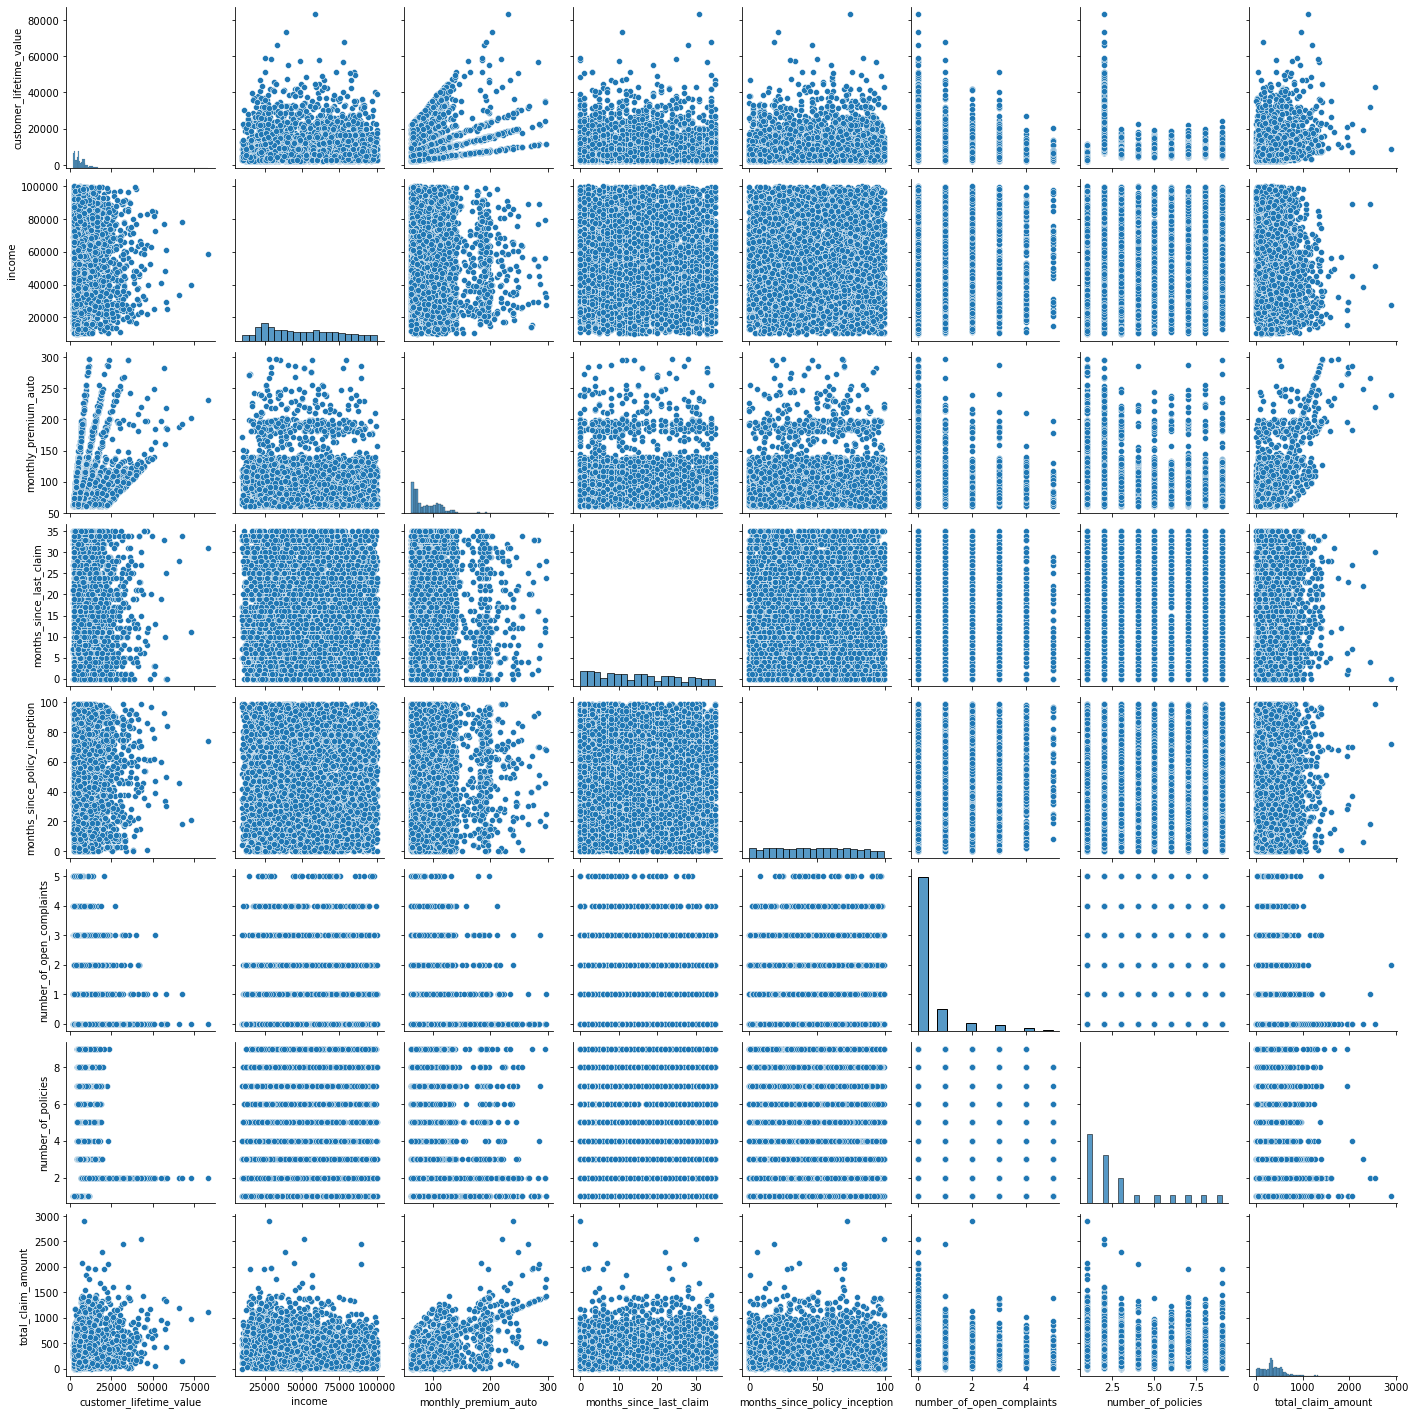

In [5]:
sns.pairplot(df)

*let`s narrow down to interesting pairs* **==>**

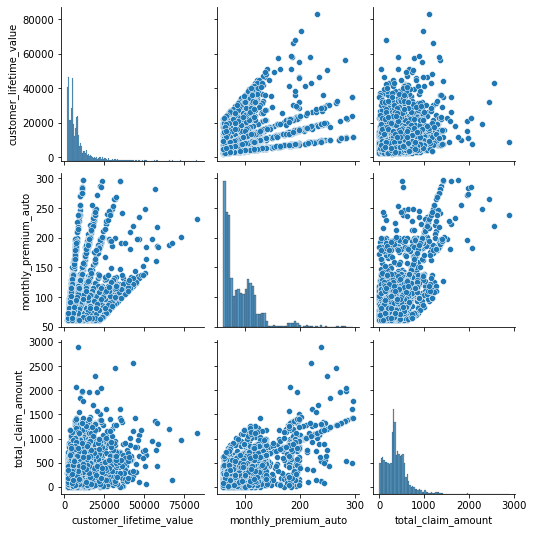

In [6]:
sns.pairplot(df[['customer_lifetime_value','monthly_premium_auto','total_claim_amount']])

*as seen on the diagonal histograms, the key features distribution are right skewed, they probably have a lot of extreme values alias outliers* **==>**

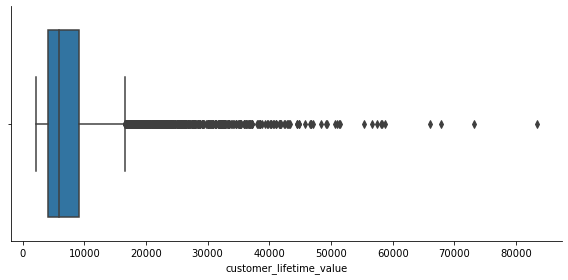

In [27]:
sns.catplot(data=df, x='customer_lifetime_value', kind='box', height=4, aspect=2)

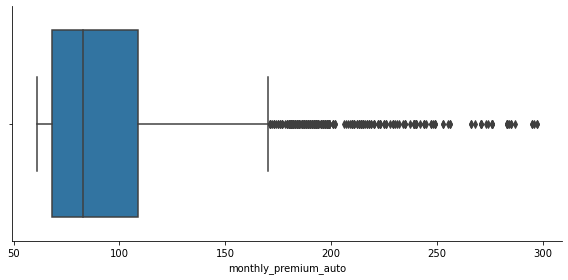

In [28]:
sns.catplot(data=df, x='monthly_premium_auto', kind='box', height=4, aspect=2)

*The skewed distribution seen and above can negatively influence our regression models performance. We shall check the categorical features as next step and then deal with this problem before building our model, so it is going to be easier to comapre its performance with and without outliers* **==>** 

#### End of Numerical features section. Click [here](#Contents) to navigate back to contents.

## Categorical features

*Now that we gained some valueable insights of the numeric columns and prepared these features for modeling, we can gain more insights of the categorical columns too* **==>** 

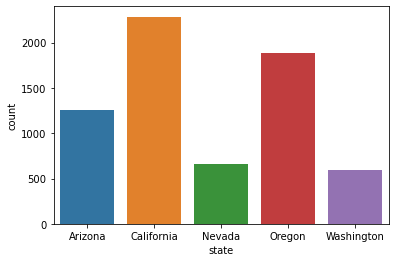

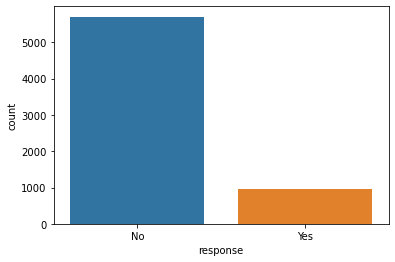

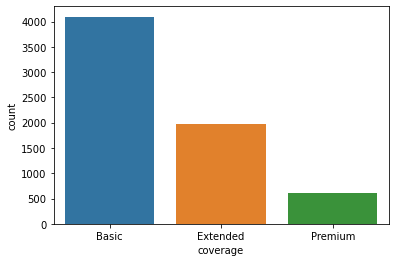

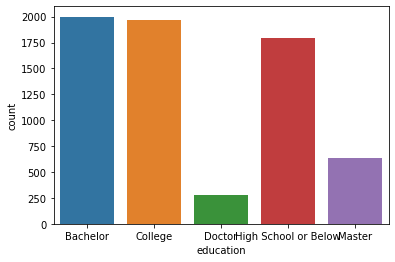

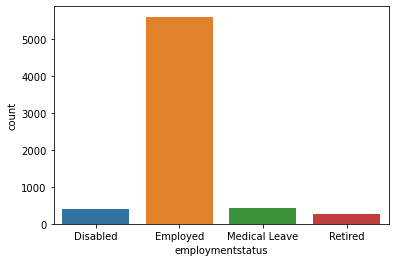

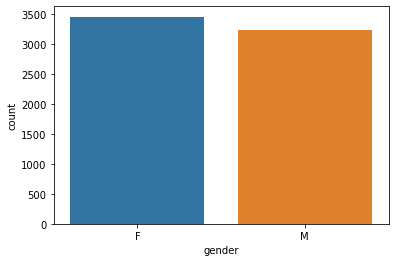

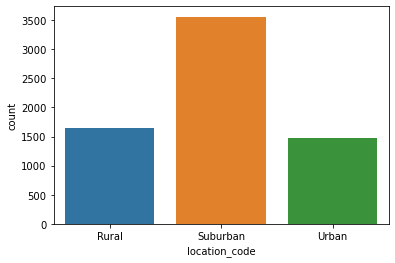

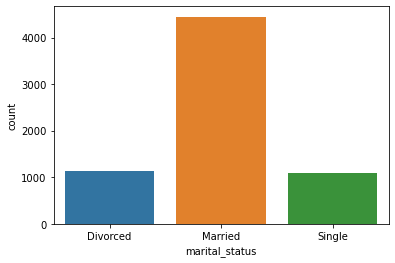

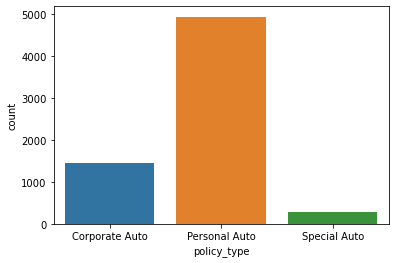

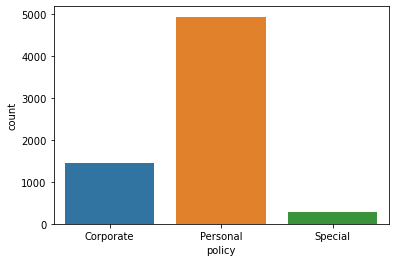

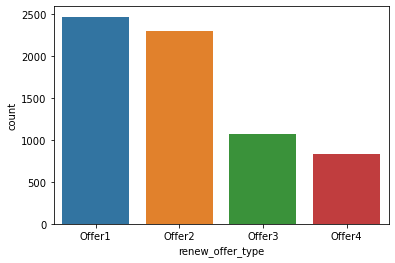

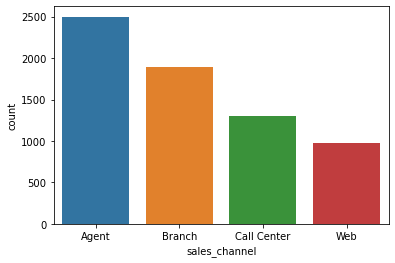

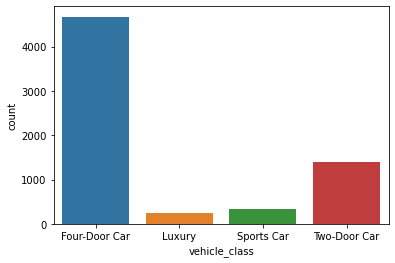

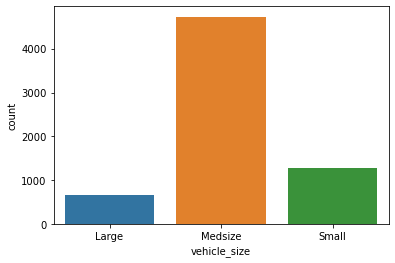

In [12]:
cat_cols = df.select_dtypes('category')

for c in (cat_cols.columns):
    sns.countplot(data=cat_cols, x=c)
    plt.show()

*Now that we have gained more insight of the categorical distribution as well, we can check more detailed relations too* **==>**

Text(0, 0.5, 'Total response')

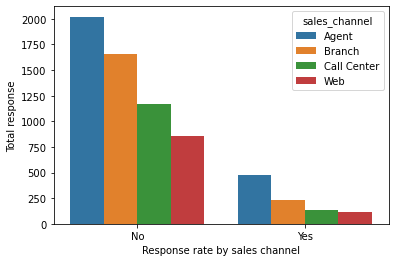

In [37]:
ax = sns.countplot(data=df, x='response', hue='sales_channel')
plt.xlabel('Response rate by sales channel')
plt.ylabel('Total response')

Text(0.5, 1.0, 'Total claim by response')

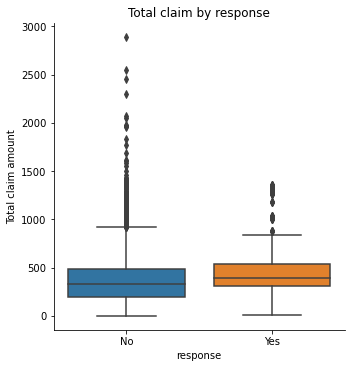

In [44]:
ax = sns.catplot(data=df, y='total_claim_amount', x='response', kind='box')
plt.ylabel('Total claim amount')
plt.title('Total claim by response')

Text(0.5, 1.0, 'Total claim by response')

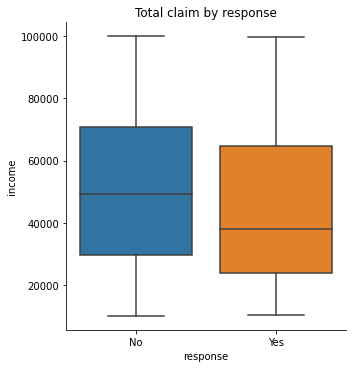

In [47]:
ax = sns.catplot(data=df, y='income', x='response', kind='box')
plt.title('Total claim by response')

#### End of categorial features section. Click [here](#Contents) to navigate back to contents.

## Data transformation

*First we calculate the **IQR**, the interquartile range of the key columns then we remove the outliers by filtering out values above and below the standard threshold (1.5 times of IQR over and below the 3rd and 1st quartile respectively)* **==>**

In [52]:
cvalue_Q1 = df['customer_lifetime_value'].quantile(0.25)
cvalue_Q3 = df['customer_lifetime_value'].quantile(0.75)
cvalue_IQR = cvalue_Q3 - cvalue_Q1

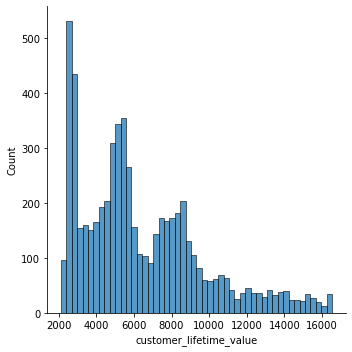

In [55]:
cvalue_mask = ((df['customer_lifetime_value'] <= cvalue_Q3+1.5*cvalue_IQR) & 
               (df['customer_lifetime_value'] >= cvalue_Q1-1.5*cvalue_IQR)
              )
cvalue_filtered = df.loc[cvalue_mask]
sns.displot(data=cvalue_filtered, x='customer_lifetime_value', bins=50)

In [56]:
pauto_Q1 = cvalue_filtered['monthly_premium_auto'].quantile(0.25)
pauto_Q3 = cvalue_filtered['monthly_premium_auto'].quantile(0.75)
pauto_IQR = pauto_Q3 - pauto_Q1

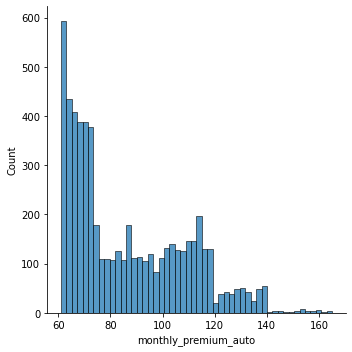

In [59]:
pauto_mask = ((cvalue_filtered['monthly_premium_auto'] <= pauto_Q3 + 1.5*pauto_IQR) & 
              (cvalue_filtered['monthly_premium_auto'] >= pauto_Q1 - 1.5*pauto_IQR)
             )
df = cvalue_filtered.loc[pauto_mask]
sns.displot(data=df, x='monthly_premium_auto', bins=50)

*The features distribution looks better, however it`s worth trying another transformation method to yield a more gaussian-like distribution in hope for better model performance* **==>** 

(array([384., 390., 254., 409., 388., 387., 192., 364.,  62., 101., 109.,
        107., 129., 120., 161., 103., 120., 114., 145., 111., 209., 118.,
        198., 209., 229., 117., 195.,  40.,  61.,  87.,  69.,  47., 101.,
          3.,   6.,   2.,   7.,  11.,   7.,   4.]),
 array([4.46817241, 4.49808674, 4.52800107, 4.5579154 , 4.58782973,
        4.61774406, 4.64765839, 4.67757272, 4.70748705, 4.73740138,
        4.76731571, 4.79723004, 4.82714437, 4.8570587 , 4.88697303,
        4.91688736, 4.94680169, 4.97671603, 5.00663036, 5.03654469,
        5.06645902, 5.09637335, 5.12628768, 5.15620201, 5.18611634,
        5.21603067, 5.245945  , 5.27585933, 5.30577366, 5.33568799,
        5.36560232, 5.39551665, 5.42543098, 5.45534531, 5.48525964,
        5.51517397, 5.54508831, 5.57500264, 5.60491697, 5.6348313 ,
        5.66474563]),
 <BarContainer object of 40 artists>)

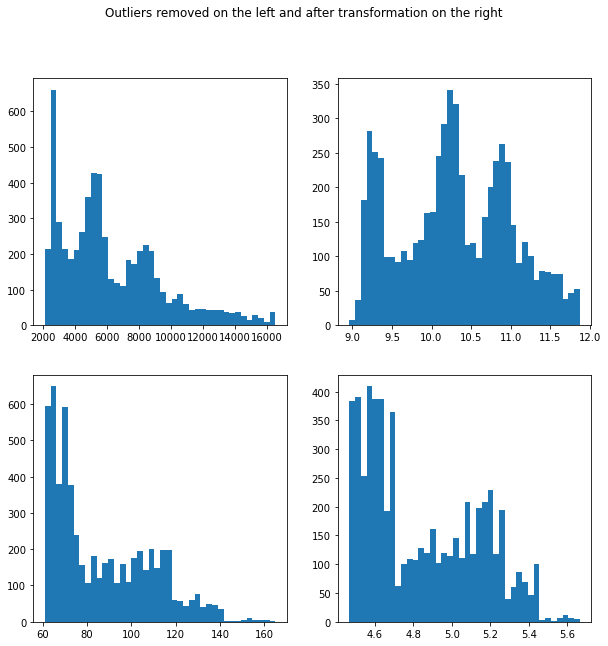

In [131]:
pt = PowerTransformer()
monthly_premium_auto_transformed=pt.fit_transform(df['monthly_premium_auto'].values.reshape(-1,1))
cvalue_transformed = boxcox(df['customer_lifetime_value'], lmbda=.04)
pauto_transformed = boxcox(df['monthly_premium_auto'], lmbda=.04)

figs, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
plt.suptitle('Outliers removed on the left and after transformation on the right')
axs[0,0].hist(x=df['customer_lifetime_value'], bins=40)
axs[0,1].hist(x=cvalue_transformed, bins=40)
axs[1,0].hist(x=df['monthly_premium_auto'], bins=40)
axs[1,1].hist(pauto_transformed, bins=40)

<AxesSubplot:xlabel='monthly_premium_auto', ylabel='total_claim_amount'>

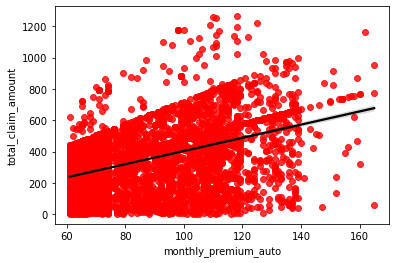

In [132]:
sns.regplot(x='monthly_premium_auto', y='total_claim_amount', 
            data=df, scatter_kws={"color": "red"}, line_kws={"color": "black"})

#### The above plotted relation is going to be an important factor when building our model. For the modeling section please follow this link: [modeling](#), or click [here](#Contents) to get back to Contents
